In [1]:
import sys
sys.path.append('../..')

import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from diffusion_gnn.core.ddpm import DDPM
from diffusion_gnn.core.scheduler import DDPMScheduler
from diffusion_gnn.models.unet import SimpleUNet
from diffusion_gnn.data.synthetic import create_toy_dataset
from diffusion_gnn.evaluation.visualization import *


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Create small dataset for quick testing
dataset = create_toy_dataset(n_samples=100, seq_len=32)
dataloader = DataLoader(TensorDataset(dataset), batch_size=8, shuffle=True)

# Get samples and unpack immediately
samples_tuple = next(iter(dataloader))
samples = samples_tuple[0]  # Unpack the tensor from TensorDataset wrapper


In [4]:
# Initialize components
scheduler = DDPMScheduler(num_timesteps=100)  # Fewer steps for quick demo
model = SimpleUNet(dim=32, channels=1).to(device)
ddpm = DDPM(model, scheduler, device)

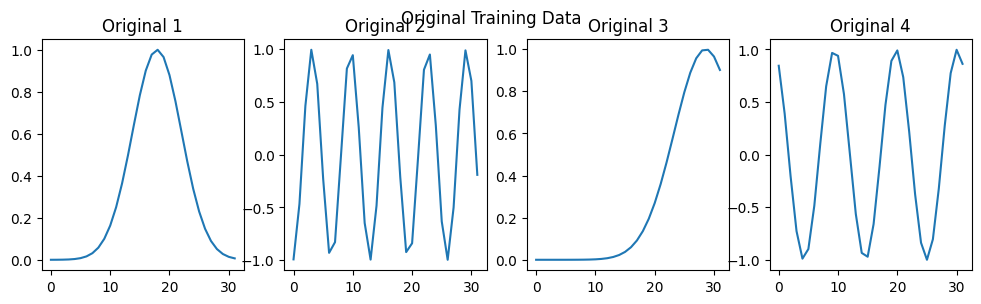

In [5]:
# Visualize original data
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(samples[i, 0].numpy())
    plt.title(f'Original {i+1}')
plt.suptitle('Original Training Data')
plt.show()

In [6]:
# Quick training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # Just a few epochs for demo
    model.train()
    total_loss = 0

    for data_tuple in dataloader:
        # Unpack data from TensorDataset
        data = data_tuple[0]  # Unpack from TensorDataset

        # Debug: Print shapes to identify the issue
        print(f"Data tuple type: {type(data_tuple)}")
        print(f"Data tuple length: {len(data_tuple)}")
        print(f"Raw data shape: {data.shape}")

        data = data.to(device)
        print(f"Data shape after .to(device): {data.shape}")

        # This should be [8, 1, 32]
        if data.shape[1] != 1:
            print(f"ERROR: Expected 1 channel, got {data.shape[1]} channels")
            break

        loss = ddpm.train_loss(data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss/len(dataloader):.4f}")

# Cell 5: Generate samples
visualize_final_samples(ddpm, device, num_samples=4, seq_len=32)

Data tuple type: <class 'list'>
Data tuple length: 1
Raw data shape: torch.Size([8, 1, 32])
Data shape after .to(device): torch.Size([8, 1, 32])
DDPM train_loss input shape: torch.Size([8, 1, 32])


RuntimeError: Given groups=1, weight of size [32, 1, 3], expected input[8, 8, 32] to have 1 channels, but got 8 channels instead